In [1]:
import os
import glob
import torch
import copy
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
class LoadData:
    def __init__(self, smoothing, horizon):
        # load data and do seperate train and test set
        X_density = glob.glob("./AEData_32/ac_density_*_smoothing_{}.npy".format(smoothing))
        X_complexity = glob.glob("./AEData_32/ev_density_*_smoothing_{}.npy".format(smoothing))
        Y = glob.glob("./AEData_32/ev_2class_density_*.npy")
        if len(X_density) != len(X_complexity):
            print("Input Dimension Mismatch! Quit!")
            return

        for idx in range(len(X_density)):
            if idx == 0:
                self.X_density = np.load(X_density[idx])[None, ...]
                self.X_complexity = np.load(X_complexity[idx])[None, ...]
                self.Y = np.load(Y[idx])[None, ...]
            else:
                self.X_density = np.concatenate((self.X_density, np.load(X_density[idx])[None, ...]), axis=0)
                self.X_complexity = np.concatenate((self.X_complexity, np.load(X_complexity[idx])[None, ...]), axis=0)
                self.Y = np.concatenate((self.Y, np.load(Y[idx])[None, ...]), axis=0)

        # concatenate the raw data as X and Y
        # self.X: 27x240x32x32x2
        # self.Y: 27x240x32x32x1
        self.X = np.concatenate((self.X_density[..., np.newaxis], self.X_complexity[..., np.newaxis]), axis=-1)
        self.Y = self.Y[..., np.newaxis]

        # shift data based on time horizon
        shift = int(horizon / 60.0)
        self.X, self.Y = self.X[:, :-shift, ...], self.Y[:, shift:, ...]

        # scale the data for better training result, won't impact optimal
        #self.X, self.Y = self.X*100, self.Y*100
        self.Y = self.Y*100

    def dataloader(self, bs, ratio):
        X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y, test_size=ratio, shuffle=True)
        X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
        Y_train, Y_test = torch.Tensor(Y_train), torch.Tensor(Y_test)

        trainloader = DataLoader(TensorDataset(X_train, Y_train), batch_size=bs, shuffle=True, num_workers=0)
        testloader = DataLoader(TensorDataset(X_test, Y_test), batch_size=bs, shuffle=True, num_workers=0)
        return trainloader, testloader

In [3]:
class AutoEncoder(nn.Module):  # input res=32, output res=32
    def __init__(self, nf):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            # input is (nc) x 64 x 64, nc=2
            nn.Conv2d(2, nf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(nf, nf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(nf * 2, nf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            # nn.Conv2d(nf * 4, nf * 2, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(nf * 2),
            # nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(nf * 4, nf * 2, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nf * 2, nf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(nf * 8, nf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(nf * 4, nf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(nf * 2, 1, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(nf),
            # nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d(nf, 1, 4, 2, 1, bias=False),
            # nn.Tanh()
            nn.ReLU()
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
smoothing = 4
horizon = 60
batch_size = 1
test_ratio = 0.1
epochs = 5000
nf = 16

# save path
save_path = './Epochs_{}_Horizon_{}_Smooth_{}'.format(epochs, horizon, smoothing)
if not os.path.exists(save_path):
    os.makedirs(save_path)
        
# load data
trainloader, testloader = LoadData(smoothing, horizon).dataloader(batch_size, test_ratio)

# load computational graph
net = AutoEncoder(nf)
if torch.cuda.is_available():
    GPU = 1
    print('Training on GPU')
    net = net.cuda()
print(net)

# setup paramaters
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.00001)
criterion = nn.MSELoss()

Training on GPU
AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(2, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 6

In [ ]:
# training and save results
trainloss = []
for epoch in range(epochs):
    training_loss = 0

    for X_train, Y_train in trainloader:
        X_train = X_train.view(-1, X_train.shape[-1], X_train.shape[-3], X_train.shape[-2])
        Y_train = Y_train.view(-1, Y_train.shape[-1], Y_train.shape[-3], Y_train.shape[-2])

        if GPU:
            X_train, Y_train = Variable(X_train).cuda(), Variable(Y_train).cuda()

        optimizer.zero_grad()
        X_pred = net(X_train)
        loss = criterion(X_pred, Y_train)
        loss.backward()
        optimizer.step()
        training_loss += loss.item() / X_train.shape[0]

    print('Epoch: {}/{} \t Mean Square Error Loss: {}'.format(epoch + 1, epochs, training_loss))
    trainloss.append(training_loss)

np.save('{}/Trainloss_Epochs_{}_Horizon_{}_Smooth_{}.npy'
            .format(save_path, epochs, horizon, smoothing), np.asarray(trainloss))

# save trained model as pth
torch.save(net.state_dict(), '{}/AE_Epochs_{}_Horizon_{}_Smooth_{}.pth'
               .format(save_path, epochs, horizon, smoothing))

Epoch: 1/5000 	 Mean Square Error Loss: 1.0667495567928298
Epoch: 2/5000 	 Mean Square Error Loss: 1.05201905541839
Epoch: 3/5000 	 Mean Square Error Loss: 1.0498746109806842
Epoch: 4/5000 	 Mean Square Error Loss: 1.0492865091587207
Epoch: 5/5000 	 Mean Square Error Loss: 1.0490466441070683
Epoch: 6/5000 	 Mean Square Error Loss: 1.0490275307180492
Epoch: 7/5000 	 Mean Square Error Loss: 1.0485716165359051
Epoch: 8/5000 	 Mean Square Error Loss: 1.0487054521568648
Epoch: 9/5000 	 Mean Square Error Loss: 1.0482567144737083
Epoch: 10/5000 	 Mean Square Error Loss: 1.0478782035316883
Epoch: 11/5000 	 Mean Square Error Loss: 1.0474130299300828
Epoch: 12/5000 	 Mean Square Error Loss: 1.0466840297108413
Epoch: 13/5000 	 Mean Square Error Loss: 1.045776933805713
Epoch: 14/5000 	 Mean Square Error Loss: 1.0448388315144943
Epoch: 15/5000 	 Mean Square Error Loss: 1.0429742426054247
Epoch: 16/5000 	 Mean Square Error Loss: 1.0406219450499723
Epoch: 17/5000 	 Mean Square Error Loss: 1.036863470

Epoch: 137/5000 	 Mean Square Error Loss: 0.3427108341679912
Epoch: 138/5000 	 Mean Square Error Loss: 0.3397007447406338
Epoch: 139/5000 	 Mean Square Error Loss: 0.33660106180103255
Epoch: 140/5000 	 Mean Square Error Loss: 0.3326295828719519
Epoch: 141/5000 	 Mean Square Error Loss: 0.3271501842403013
Epoch: 142/5000 	 Mean Square Error Loss: 0.32802951485542076
Epoch: 143/5000 	 Mean Square Error Loss: 0.33045122563589563
Epoch: 144/5000 	 Mean Square Error Loss: 0.3304753313503504
Epoch: 145/5000 	 Mean Square Error Loss: 0.3284201691838987
Epoch: 146/5000 	 Mean Square Error Loss: 0.33023042359611476
Epoch: 147/5000 	 Mean Square Error Loss: 0.32898017951135355
Epoch: 148/5000 	 Mean Square Error Loss: 0.3248165377014352
Epoch: 149/5000 	 Mean Square Error Loss: 0.3195760334884772
Epoch: 150/5000 	 Mean Square Error Loss: 0.31320617388481864
Epoch: 151/5000 	 Mean Square Error Loss: 0.31389368129075823
Epoch: 152/5000 	 Mean Square Error Loss: 0.31488009127612887
Epoch: 153/5000 

Epoch: 271/5000 	 Mean Square Error Loss: 0.27603604604010806
Epoch: 272/5000 	 Mean Square Error Loss: 0.2754497687686936
Epoch: 273/5000 	 Mean Square Error Loss: 0.27463351183855383
Epoch: 274/5000 	 Mean Square Error Loss: 0.27405860434017415
Epoch: 275/5000 	 Mean Square Error Loss: 0.27469500188548196
Epoch: 276/5000 	 Mean Square Error Loss: 0.2754092974642829
Epoch: 277/5000 	 Mean Square Error Loss: 0.273670134684032
Epoch: 278/5000 	 Mean Square Error Loss: 0.2724295485468589
Epoch: 279/5000 	 Mean Square Error Loss: 0.2722752747675365
Epoch: 280/5000 	 Mean Square Error Loss: 0.27175003564507394
Epoch: 281/5000 	 Mean Square Error Loss: 0.2747773989473926
Epoch: 282/5000 	 Mean Square Error Loss: 0.2767120470062958
Epoch: 283/5000 	 Mean Square Error Loss: 0.2756722133029954
Epoch: 284/5000 	 Mean Square Error Loss: 0.2751406161854955
Epoch: 285/5000 	 Mean Square Error Loss: 0.2751499409456133
Epoch: 286/5000 	 Mean Square Error Loss: 0.2736848088986704
Epoch: 287/5000 	 Me

Epoch: 405/5000 	 Mean Square Error Loss: 0.26901109996699885
Epoch: 406/5000 	 Mean Square Error Loss: 0.2693834658945954
Epoch: 407/5000 	 Mean Square Error Loss: 0.2700259999750049


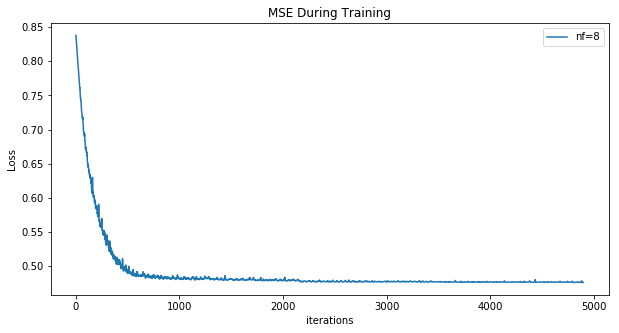

In [6]:
# visualization
plt.figure(figsize=(10, 5))
plt.title("MSE During Training")
plt.plot(trainloss[100:], label="nf={}".format(nf))
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
# plt.show()
plt.savefig('{}/Trainloss_Epochs_{}_Horizon_{}_Smooth_{}.png'
                .format(save_path, epochs, horizon, smoothing), dpi=300)

In [8]:
# test on testing dataset
X_test, Y_test = next(iter(testloader))
X_test = X_test.view(-1, X_test.shape[-1], X_test.shape[-3], X_test.shape[-2])
Y_test = Y_test.view(-1, Y_test.shape[-1], Y_test.shape[-3], Y_test.shape[-2])
if GPU:
    X_test = Variable(X_test).cuda()
    Y_pred = net(X_test)

for num in range(Y_test.shape[0]):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(Y_test[num, 0, :, :].cpu(), origin='lower', cmap='Blues')

    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(Y_pred[num, 0, :, :].cpu().detach(), origin='lower', cmap='Blues')

    plt.savefig('{}/AE_{}.png'.format(save_path, num), dpi=300)
    plt.close(fig)